In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

## Step 1. Download and compile the fpocket software from GitHub.
### Make sure you can reproduce the examples given.

In [2]:
with open("Data/1ATP_info.txt") as f:
    lines = f.readlines()

## Step 2. Filter the pockets to keep only the ones with draggability > 0.5

In [3]:
for ind,i in enumerate(lines):
    if "Druggability Score" in i and float((i.split()[3])) > 0.5:
        print("Pocket with score > 0.5 is Pocket", lines[ind-2].split()[1])

Pocket with score > 0.5 is Pocket 1


## Step 3. Assume ONE pqr file is the input, which contains the alpha spheres defining the pocket.

In [4]:
with open('Data/1ATP_pockets.txt') as infile:
    # Read space-delimited file and replace all empty spaces by commas
    data = infile.read().replace('    ', ',')
    # Write the CSV data in the output file
    print(data, file=open('Data/1ATP_pockets.txt', 'w'))

df = pd.read_csv('Data/1ATP_pockets.txt', sep=',',header=None)
df.rename(columns = {0:'Type',1:'Atom ID',2:'Element',3:'Pocket ID',4:'xyz',5:'__',6:'r'}, inplace = True)

x = []
y = []
z = []

for i in range(len(df)):
    
    dummy = df['xyz'][i].split(' ')
    filtered_list = [item for item in dummy if item != '']
    x.append(float(filtered_list[0]))
    y.append(float(filtered_list[1]))
    z.append(float(filtered_list[2]))
    
df['x']=x
df['y']=y
df['z']=z
df.drop(['xyz', '__'], axis=1,inplace = True)

pocket_1 = df[df['Pocket ID'] == 1]

## Step 4. Compute the bounding box (min/max xyz) of the alpha spheres, counting their centres and radii. Call it x_min and x_max (both are in R^3)

In [5]:
x_min = min(pocket_1['x']+pocket_1['r'])
y_min = min(pocket_1['y']+pocket_1['r'])
z_min = min(pocket_1['z']+pocket_1['r'])

x_max = max(pocket_1['x']+pocket_1['r'])
y_max = max(pocket_1['y']+pocket_1['r'])
z_max = max(pocket_1['z']+pocket_1['r'])

xyz_min = np.array([x_min,y_min,z_min])

xyz_max = np.array([x_max,y_max,z_max])

In [6]:
def plot_max_min(xyz_min,xyz_max,L=None,center=None,use_L=False,use_center=False):

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    if use_center == True and use_L == True:
        ax.scatter([center[0], center[0]], [center[1], center[1]], [center[2], center[2]],c='g', marker='o')
        ax.scatter([xyz_min[0]-L, xyz_max[0]+L], [xyz_min[1]-L, xyz_max[1]+L], [xyz_min[2]-L, xyz_max[2]+L],c='b', marker='o')
        ax.scatter([xyz_min[0], xyz_max[0]], [xyz_min[1], xyz_max[1]], [xyz_min[2], xyz_max[2]],c='r', marker='x')

    if use_center == True and use_L == False:
        ax.scatter([center[0], center[0]], [center[1], center[1]], [center[2], center[2]],c='g', marker='o')
        ax.scatter([xyz_min[0], xyz_max[0]], [xyz_min[1], xyz_max[1]], [xyz_min[2], xyz_max[2]],c='r', marker='x')

    if use_center == False and use_L == True:
        ax.scatter([xyz_min[0]-L, xyz_max[0]+L], [xyz_min[1]-L, xyz_max[1]+L], [xyz_min[2]-L, xyz_max[2]+L],c='b', marker='o')
        ax.scatter([xyz_min[0], xyz_max[0]], [xyz_min[1], xyz_max[1]], [xyz_min[2], xyz_max[2]],c='r', marker='x')

    else:
        ax.scatter([xyz_min[0], xyz_max[0]], [xyz_min[1], xyz_max[1]], [xyz_min[2], xyz_max[2]],c='b', marker='o')
    
    # Set the plot limits and labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.show()

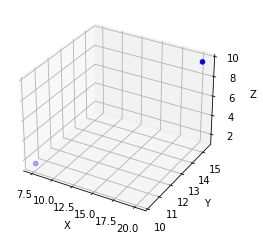

In [7]:
plot_max_min(xyz_min,xyz_max)

## Step 5. Add a margin L to each side of the bounding box.

In [8]:
L = 5

xyz_min_L = np.array([i - L for i in xyz_min])
xyz_max_L = np.array([i + L for i in xyz_max])

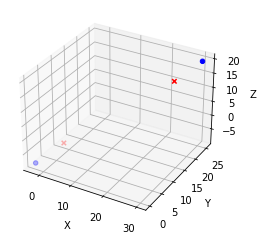

In [9]:
plot_max_min(xyz_min_L,xyz_max_L,L,use_L=True)

## Step 6. Find the center of the bounding box. x_0 (also in R^3)

The center of the bounding box is: [13.856  12.8145  5.568 ]


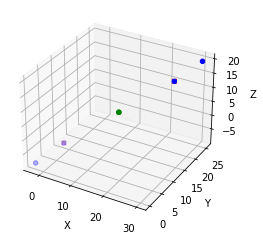

In [10]:
# Calculate the center point
center = (xyz_min_L + xyz_max_L) / 2

print("The center of the bounding box is:", center)
plot_max_min(xyz_min_L,xyz_max_L,L,center,use_L=True,use_center=True)

## Step 7. Compute the coordinates of an IMAGINARY 3d grid centred on x_0 . The grid spacing must be dX (given, but you can assume 1 Å). The grid must have enough points to cover the whole bounding box + L. The grid must be square, so round up as necessary. Please see the diagram attached. 

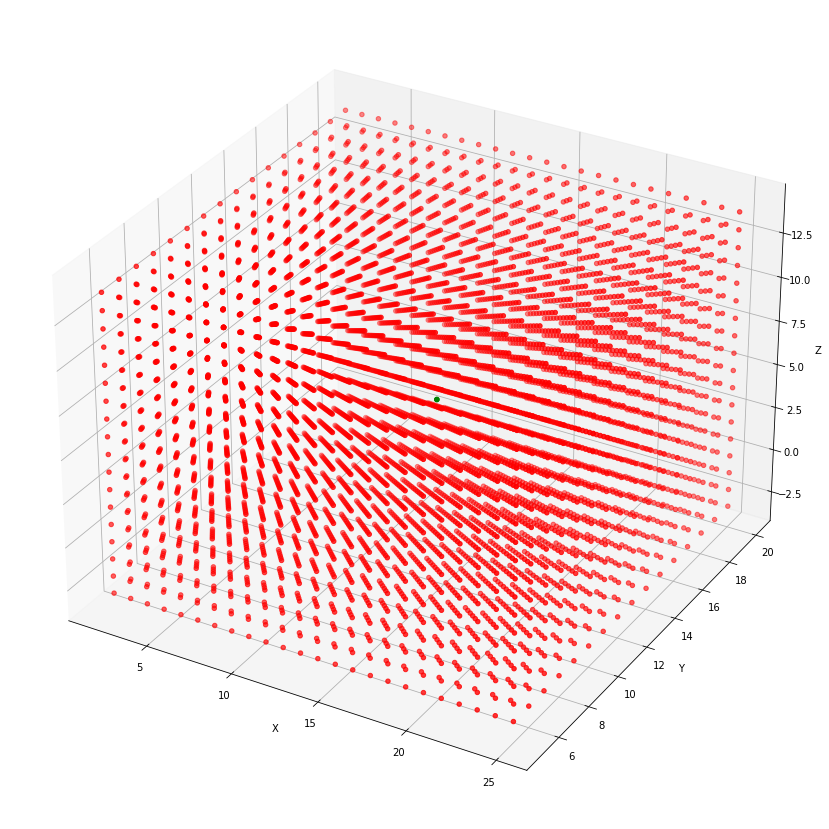

[13.856  12.8145  5.568 ]


In [18]:
n = np.linspace(int(xyz_min_L[0]),int(xyz_max_L[0]),(int(xyz_max_L[0])-int(xyz_min_L[0])+1))
m = np.linspace(int(xyz_min_L[1]),int(xyz_max_L[1]),(int(xyz_max_L[1])-int(xyz_min_L[1])+1))
k = np.linspace(int(xyz_min_L[2]),int(xyz_max_L[2]),(int(xyz_max_L[2])-int(xyz_min_L[2])+1))

coordinates = np.array([(i, j, l) for i in n for j in m for l in k])

# Create a 3D plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Plot the grid of points
ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c='r')
center = (xyz_min_L + xyz_max_L) / 2
ax.scatter([center[0], center[0]], [center[1], center[1]], [center[2], center[2]],c='g', marker='o')


# Set the plot limits and labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()
print(center)

## Step 8. Each cell of the grid will have its coordinates, x_i. For each cell, compute its value v_i as follows: if x_i is inside any alpha-sphere, assign 1, otherwise 0. 

In [130]:
X,Y,Z = pocket_1['x'],pocket_1['y'],pocket_1['z']

# Combine the vectors into a matrix
pocket_matrix = np.array([X, Y, Z]).T

inside = []

# Compare the elements of the two matrices
for ind_p, p in enumerate(pocket_matrix):
    for ind, i in enumerate(coordinates):
        if np.abs(i - p)[0] < 1 and np.abs(i - p)[1] < 1 and np.abs(i - p)[2] < 1:
            inside.append([i,1])
        else:
            inside.append([i,0])

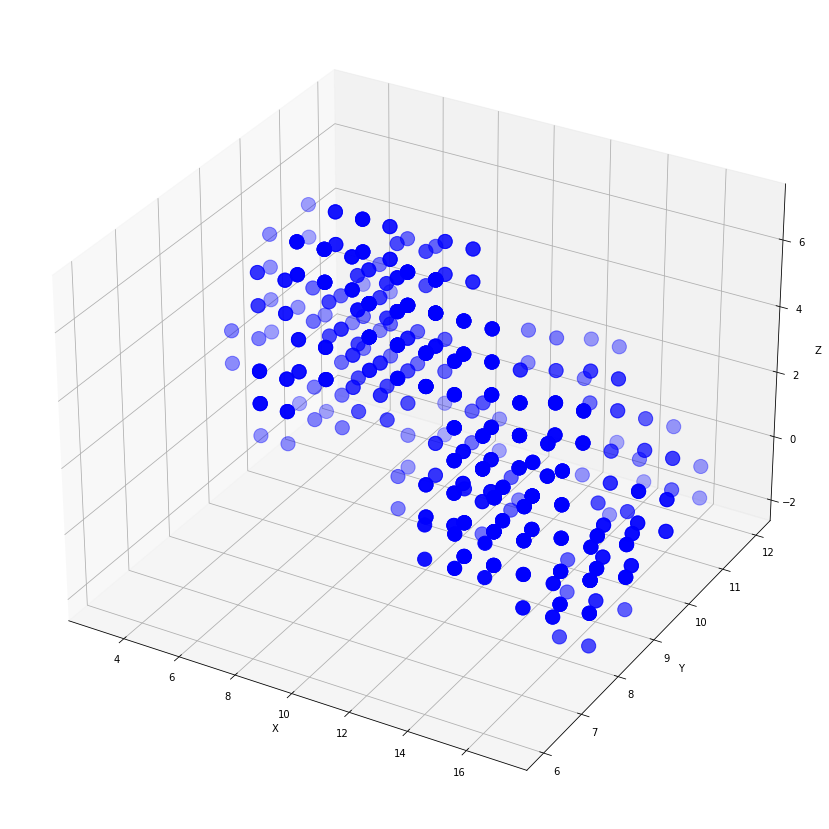

In [136]:
# Extract the coordinates and values from the sublists
coords = np.array([lst_elem[0] for lst_elem in inside])
values = np.array([lst_elem[1] for lst_elem in inside])

# Create a 3D scatter plot of the points with red for value 0 and blue for value 1
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[values == 1, 0], coords[values == 1, 1], coords[values == 1, 2], c='b',s=200)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

## Step 9. It should be implemented as  a Python  function. Return the grid (i.e. its coordinates, bounding box, values etc) as an object or dictionary of your choice.

In [141]:
def inside_pocket(pocket_1):
    
    x_min = min(pocket_1['x']+pocket_1['r'])
    y_min = min(pocket_1['y']+pocket_1['r'])
    z_min = min(pocket_1['z']+pocket_1['r'])

    x_max = max(pocket_1['x']+pocket_1['r'])
    y_max = max(pocket_1['y']+pocket_1['r'])
    z_max = max(pocket_1['z']+pocket_1['r'])

    xyz_min = np.array([x_min,y_min,z_min])

    xyz_max = np.array([x_max,y_max,z_max])
    
    L = 5

    xyz_min_L = np.array([i - L for i in xyz_min])
    
    xyz_max_L = np.array([i + L for i in xyz_max])
    
    center = (xyz_min_L + xyz_max_L) / 2
    
    # Define the coordinate grid
    n = np.linspace(int(xyz_min_L[0]),int(xyz_max_L[0]),(int(xyz_max_L[0])-int(xyz_min_L[0])+1))
    m = np.linspace(int(xyz_min_L[1]),int(xyz_max_L[1]),(int(xyz_max_L[1])-int(xyz_min_L[1])+1))
    k = np.linspace(int(xyz_min_L[2]),int(xyz_max_L[2]),(int(xyz_max_L[2])-int(xyz_min_L[2])+1))

    coordinates = np.array([(i, j, l) for i in n for j in m for l in k])
    
    X,Y,Z = pocket_1['x'],pocket_1['y'],pocket_1['z']

    # Define the pocket grid into a matrix
    pocket_matrix = np.array([X, Y, Z]).T

    inside = []

    # Compare the elements of the two matrices, if they are close by 1 unit, the coordinate is inside the pocket matrix
    for ind_p, p in enumerate(pocket_matrix):
        for ind, i in enumerate(coordinates):
            if np.abs(i - p)[0] < 1 and np.abs(i - p)[1] < 1 and np.abs(i - p)[2] < 1:
                inside.append([i,1])
            else:
                inside.append([i,0])
                
    # Extract the coordinates and values from the sublists
    coords = np.array([lst_elem[0] for lst_elem in inside])
    values = np.array([lst_elem[1] for lst_elem in inside])

    # Create a 3D scatter plot of the points with red for value 0 and blue for value 1
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[values == 1, 0], coords[values == 1, 1], coords[values == 1, 2], c='b',s=200)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
    # Initialize an empty dictionary
    inside_dict = {}

    # Loop over the list and add each coordinate and its corresponding value to the dictionary
    for coord, val in inside:
        inside_dict[tuple(coord)] = val
        
    print("The margin of the grid is:", L)
    print("The center of the grid is:", center)
    print("The max of the xyz is:", xyz_max)
    print("The min of the xyz is:", xyz_min)
    
    return inside_dict
    

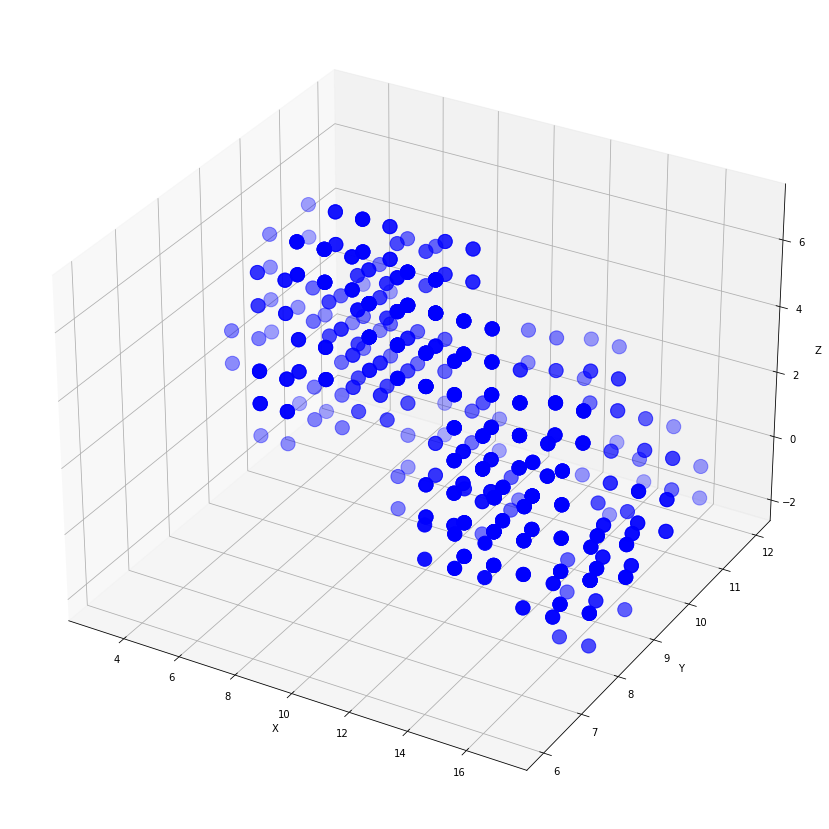

The margin of the grid is: 5
The center of the grid is: [13.856  12.8145  5.568 ]
The max of the xyz is: [20.348 15.401  9.613]
The min of the xyz is: [ 7.364 10.228  1.523]


In [145]:
file = inside_pocket(pocket_1)

## Step 10. Write the grid as a numpy object and, if possible, as a OpenDX  grid file (format described here). This is the goal of the project.

In [148]:
file

{(2.0, 5.0, -3.0): 0,
 (2.0, 5.0, -2.0): 0,
 (2.0, 5.0, -1.0): 0,
 (2.0, 5.0, 0.0): 0,
 (2.0, 5.0, 1.0): 0,
 (2.0, 5.0, 2.0): 0,
 (2.0, 5.0, 3.0): 0,
 (2.0, 5.0, 4.0): 0,
 (2.0, 5.0, 5.0): 0,
 (2.0, 5.0, 6.0): 0,
 (2.0, 5.0, 7.0): 0,
 (2.0, 5.0, 8.0): 0,
 (2.0, 5.0, 9.0): 0,
 (2.0, 5.0, 10.0): 0,
 (2.0, 5.0, 11.0): 0,
 (2.0, 5.0, 12.0): 0,
 (2.0, 5.0, 13.0): 0,
 (2.0, 5.0, 14.0): 0,
 (2.0, 6.0, -3.0): 0,
 (2.0, 6.0, -2.0): 0,
 (2.0, 6.0, -1.0): 0,
 (2.0, 6.0, 0.0): 0,
 (2.0, 6.0, 1.0): 0,
 (2.0, 6.0, 2.0): 0,
 (2.0, 6.0, 3.0): 0,
 (2.0, 6.0, 4.0): 0,
 (2.0, 6.0, 5.0): 0,
 (2.0, 6.0, 6.0): 0,
 (2.0, 6.0, 7.0): 0,
 (2.0, 6.0, 8.0): 0,
 (2.0, 6.0, 9.0): 0,
 (2.0, 6.0, 10.0): 0,
 (2.0, 6.0, 11.0): 0,
 (2.0, 6.0, 12.0): 0,
 (2.0, 6.0, 13.0): 0,
 (2.0, 6.0, 14.0): 0,
 (2.0, 7.0, -3.0): 0,
 (2.0, 7.0, -2.0): 0,
 (2.0, 7.0, -1.0): 0,
 (2.0, 7.0, 0.0): 0,
 (2.0, 7.0, 1.0): 0,
 (2.0, 7.0, 2.0): 0,
 (2.0, 7.0, 3.0): 0,
 (2.0, 7.0, 4.0): 0,
 (2.0, 7.0, 5.0): 0,
 (2.0, 7.0, 6.0): 0,
 (2.0, 7.0, 7.0